In [0]:
# !pip install quandl
# !pip install pyramid-arima
# !pip uninstall statsmodels
# !pip install statsmodels --upgrade

In [0]:
import quandl
# from fbprophet import Prophet
# from AT.visualization.plotly_charts import plot_ts
quandl.ApiConfig.api_key = '*****'

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import pandas as pd
import numpy as np
# import AT.data_io.quandl_io as quandl_io
from datetime import datetime
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pyramid.arima import auto_arima

%matplotlib inline

In [96]:
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

def plot_ts(ts, chart_title='',  x_label='', y_label='', output_filename=''):
    if isinstance(ts, pd.DataFrame):
        trace_list = [go.Scatter(x=pd.to_datetime(ts.index).strftime('%Y-%m-%d'), y=ts[s], name=s) for s in ts]
    elif isinstance(ts, pd.Series):
        trace_list = [go.Scatter(x=pd.to_datetime(ts.index).strftime('%Y-%m-%d'), y=ts, name=ts.name)]
    elif isinstance(ts, list):
        for s in ts:
            if not isinstance(s, pd.Series):
                raise ValueError('list instance is not pd.Series')
        trace_list = [go.Scatter(x=pd.to_datetime(s.index).strftime('%Y-%m-%d'), y=s, name=s.name) for s in ts]
    else:
        return

    fig = go.Figure(data=trace_list,
                    layout=go.Layout(title=chart_title, xaxis=dict(title=x_label), yaxis=dict(title=y_label)))

    # plot(fig, filename=output_filename)
    iplot(fig)

In [0]:
start_date = '2000-01-01'

# 1. load EOD data
tickers = ['GOOGL']
data_sep = quandl.get_table('SHARADAR/SEP', date={'gte': start_date}, qopts={"columns": ['ticker', 'date', 'close']}, ticker=tickers, paginate=True)
# data_sep.to_csv(f'../data/GOOGL_from_{start_date}.csv', index=False)
# data_sep = pd.read_csv(f'../data/GOOGL_from_{start_date}.csv')
close = data_sep.pivot(columns='ticker', index='date', values='close')
close.index = pd.to_datetime(close.index)

# Analysis

In [98]:
train_test_split = '2018-07-01'
ticker = tickers[0]

y = close[ticker].resample('M').mean()
# y = close[ticker].rolling(20).mean()
y.shape

(129,)

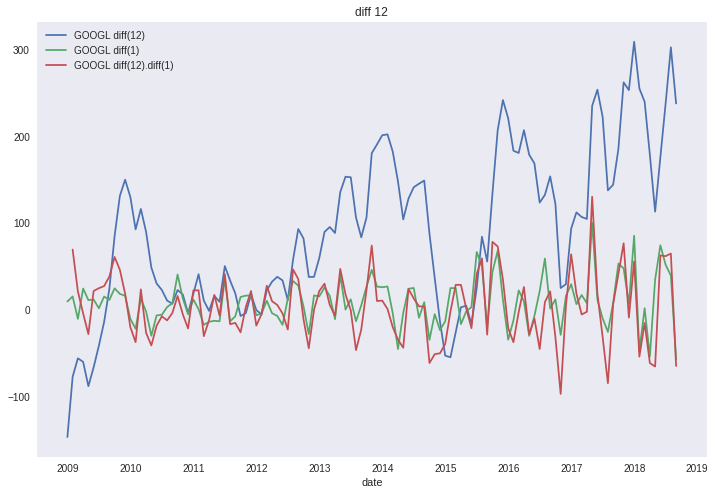

In [99]:
d = 12
diff = close[ticker].resample('M').mean().diff(d).iloc[d:].rename(f'{y.name} diff({d})').to_frame()
diff[f'{y.name} diff(1)'] = close[ticker].resample('M').mean().diff(1).iloc[1:].rename(f'{y.name} diff(1)')
# diff[f'{y.name} pct_change(1)'] = close[ticker].resample('M').mean().pct_change().iloc[1:]
diff[f'{y.name} diff(12).diff(1)'] = close[ticker].resample('M').mean().diff(12).iloc[d:].diff(1).iloc[1:].rename(f'{y.name} diff(12).diff(1)')

diff.plot(title=f'diff {d}', figsize=(12, 8), secondary_y=f'{y.name} pct_change(1)')

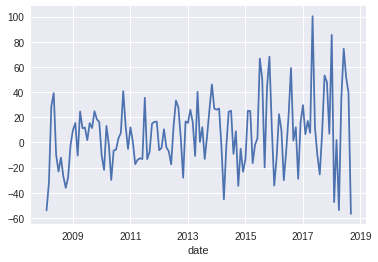

In [100]:
train_test_split = '2018-07-01'
ticker = tickers[0]
# y = close[ticker].resample('M').mean().diff(12).iloc[12:].diff(1).iloc[1:]
y = close[ticker].resample('M').mean().diff(1).iloc[1:]

y.plot()

**Check Stationarity**

In [101]:
# statsmodels.tsa.stattools.kpss(y)
statsmodels.tsa.stattools.adfuller(y)[1]  # p < 0.05 => stationary

0.0008586054071816545

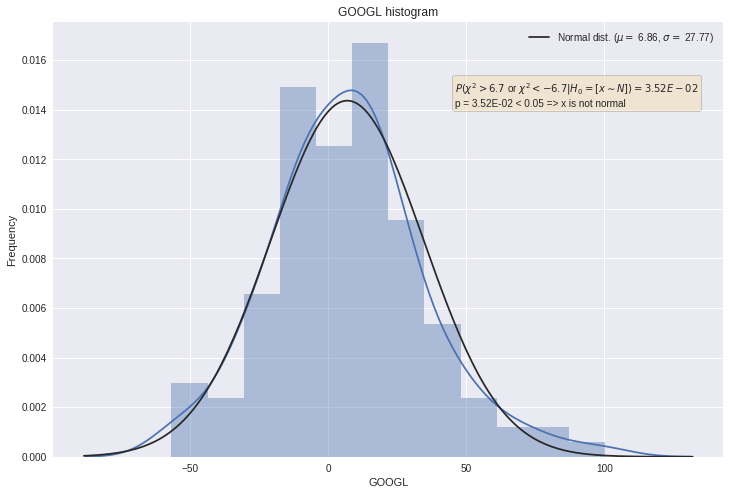

In [102]:
def hist_plot(x):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.distplot(x , fit=norm, ax=ax)

    mu, sigma = norm.fit(x)

    #Now plot the distribution
    plt.legend([f'Normal dist. ($\mu=$ {mu:.2f}, $\sigma=$ {sigma:.2f})'], loc='best')
    plt.ylabel('Frequency'), plt.title(f'{x.name} histogram')

    t, p = stats.normaltest(x)
    text = f'$P(\chi^2 > {round(t,1)}$ or $\chi^2 < {-round(t,1)} | H_0 = [x \sim N]) = {p:.2E}$'\
           f'\np = {p:.2E} {"< 0.05 => x is not normal" if p < 0.05 else "=> H_0 is not rejected"}'

    ax.text(0.6, 0.87, text, transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
boxcox_with_neg = lambda x: stats.boxcox(x - min(x[x<0]))[0]

hist_plot(y)
# hist_plot(boxcox_with_neg(x))
# hist_plot(pd.Series(stats.boxcox(x+1)[0], name=x.name))

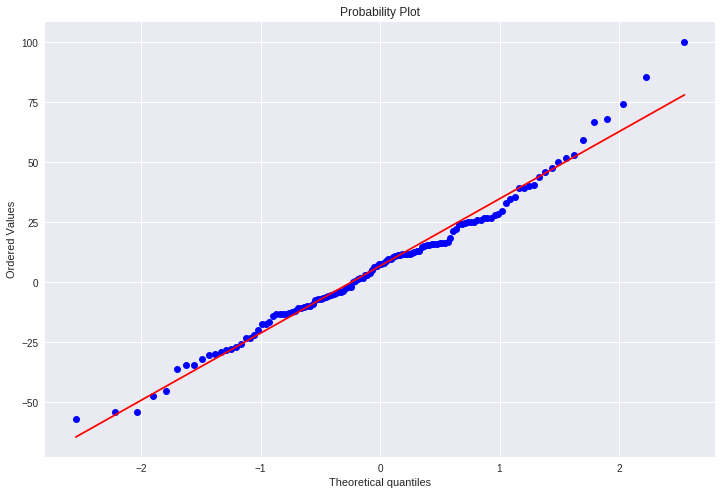

In [103]:
# QQ-plot
fig = plt.figure(figsize=(12, 8))
res = stats.probplot(y, plot=plt)
plt.show()

In [104]:
pd.DataFrame({f'{x.name}': x, f'boxcox({x.name})': stats.boxcox(1+x)[0]}, index=x.index).plot(
    secondary_y=f'boxcox({x.name})', figsize=(12, 8))

ValueError: ignored

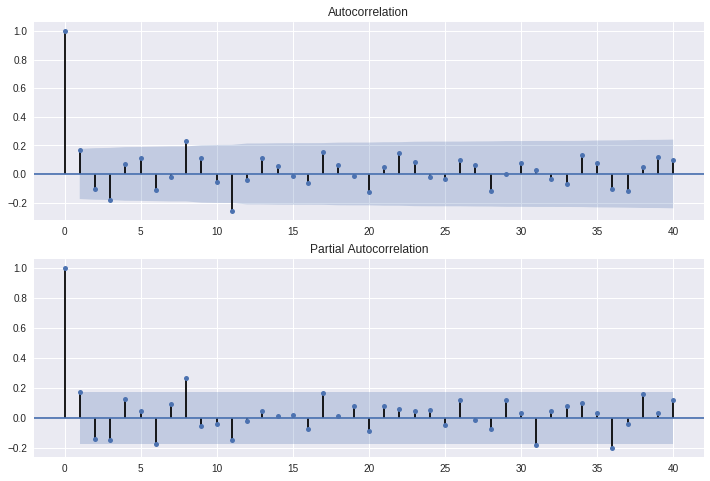

In [71]:
# ACF, PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y.loc[start_date:train_test_split].values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y.loc[start_date:train_test_split].values, lags=40, ax=ax2)

In [0]:
# y.resample('M').mean().plot(figsize=(12, 8))
# plot_ts(y)#, y.diff().iloc[1:].rename('y diff'))
# y.loc['2017-10':].rolling(10).mean().diff().apply(lambda x: np.log(100+x)).iloc[1:].rename('y diff').plot(figsize=(12, 8))
# import scipy
# t = scipy.fft(y)
# t[0] = 0
# pd.Series(np.abs(scipy.fft(t[:len(t)//2]))).plot(figsize=(15, 10))

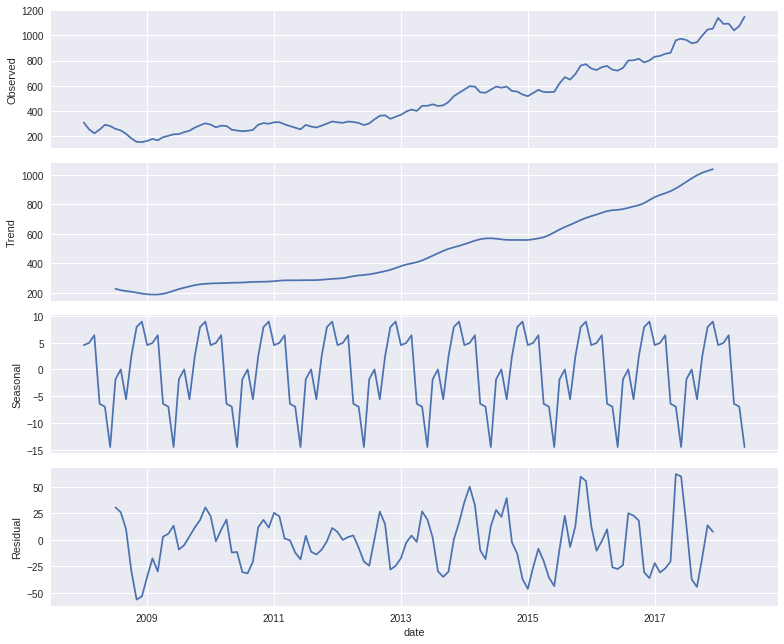

In [79]:
# https://gist.github.com/balzer82/5cec6ad7adc1b550e7ee

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

stl = seasonal_decompose(close[ticker].loc[start_date: train_test_split].resample('M').mean(),)# model='multiplicative')
mpl_fig = stl.plot()

# plot_ts(y, chart_title=y.name)
# plot_ts(stl.trend, chart_title='trend')
# plot_ts(stl.seasonal, chart_title='seasonal')
# plot_ts(stl.resid, chart_title='resid')

# Convert to plotly chart
# fig = tls.mpl_to_plotly(mpl_fig)
# fig['layout']['height'] = 300
# fig['layout']['width'] = 480
# iplot(fig)

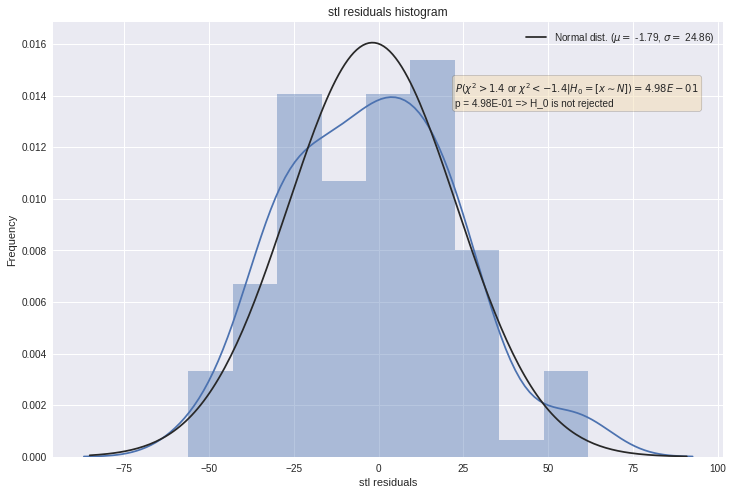

In [80]:
hist_plot(stl.resid.dropna().rename('stl residuals'))

# auto_arima

In [50]:
model = auto_arima(
    y.loc[start_date:train_test_split], 
    start_p=0, max_p=4, start_q=0, max_q=4, max_d=4, 
    start_P=0, max_P=2, start_Q=0, max_Q=2, start_D=0, max_D=2, m=12, trace=False,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
    stepwise=True  # set to stepwise
)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  126
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -582.402
Date:                Fri, 28 Sep 2018   AIC                           1172.804
Time:                        08:34:42   BIC                           1184.085
Sample:                             0   HQIC                          1177.387
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1860      0.068      2.722      0.006       0.052       0.320
ma.L1         -0.8166     15.593     -0.052      0.958     -31.378      29.744
ma.L2         -0.1833      2.886     -0.063      0.949      -5.841       5.474
sigma2       678.2547   1.06e+04      0.064      0.949   -2.01e+04    2.14e+04
===================================================================================
Ljung-Box (Q):                       62.00   Jarque-Bera (JB):                 6.02
Prob(Q):                              0.01   Prob(JB):                         0.05
Heteroskedasticity (H):               3.22   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA

In [228]:
train_test_split = '2016-01-01'  # '2018-07-01'
ticker = tickers[0]
y = close[ticker].resample('M').mean() #.diff().iloc[1:]


order = (8,1,0)
seasonal_order = (1,1,0,12)
model = sm.tsa.statespace.SARIMAX(
    y.loc[start_date:],#train_test_split], 
    exog=None, 
    order=order, seasonal_order=seasonal_order, 
    trend='t' #[1,1,1]#'ct'
).fit(disp=True)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              GOOGL   No. Observations:                  129
Model:             SARIMAX(8, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -554.382
Date:                            Fri, 28 Sep 2018   AIC                           1130.764
Time:                                    11:44:06   BIC                           1161.053
Sample:                                01-31-2008   HQIC                          1143.060
                                     - 09-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0379      0.039      0.967      0.333      -0.039       0.115
ar.L1          0.2397      0.105      2.285      0.022       0.034       0.445
ar.L2         -0.1157      0.117     -0.990      0.322      -0.345       0.113
ar.L3         -0.3242      0.105     -3.075      0.002      -0.531      -0.118
ar.L4          0.1759      0.126      1.398      0.162      -0.071       0.422
ar.L5          0.0070      0.112      0.062      0.951      -0.213       0.227
ar.L6         -0.2116      0.112     -1.884      0.060      -0.432       0.009
ar.L7          0.0608      0.113      0.537      0.591      -0.161       0.282
ar.L8          0.1692      0.091      1.857      0.063      -0.009       0.348
ar.S.L12      -0.5741      0.102     -5.644      0.000      -0.773      -0.375
sigma2       788.3184    116.506      6.766      0.000     559.971    1016.666
===================================================================================
Ljung-Box (Q):                       30.32   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.87   Prob(JB):                         0.57
Heteroskedasticity (H):               2.30   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

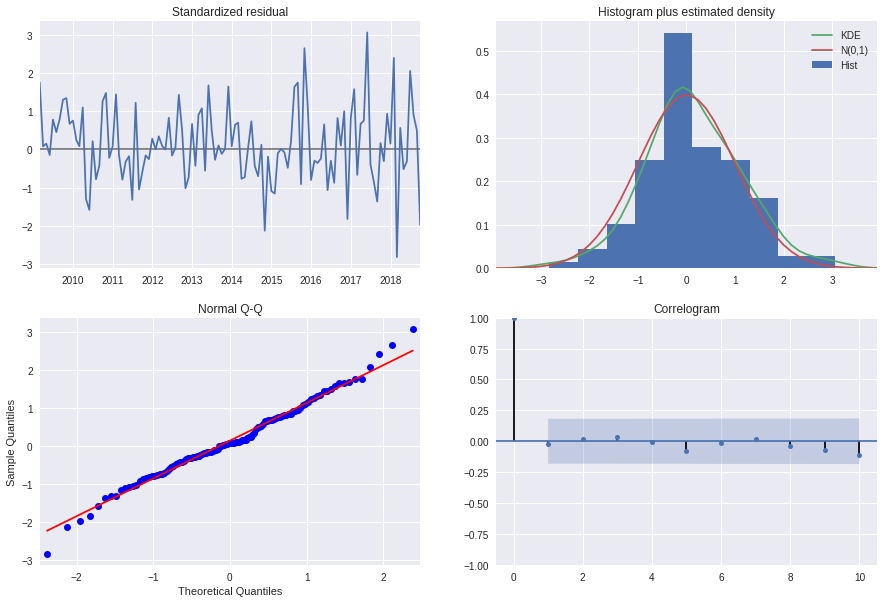

(<matplotlib.figure.Figure at 0x7efe00726358>, None)

In [220]:
model.plot_diagnostics(figsize=(15, 10)), plt.show()

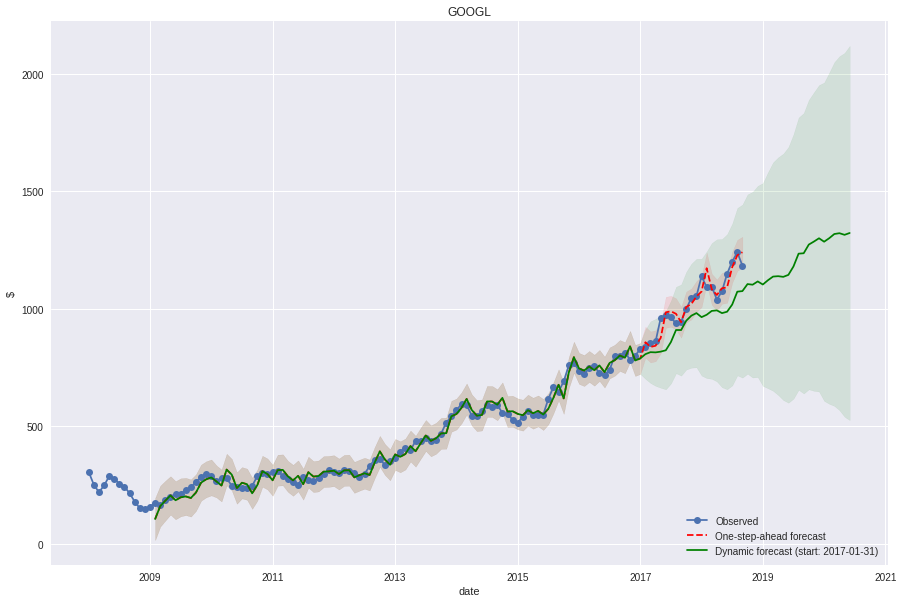

In [226]:
# In-sample one-step-ahead predictions
predict = model.get_prediction()
predict_ci = predict.conf_int()

# Dynamic predictions
dynamic_forecast_start = '2017-01-31'
nforecast = 20
predict_dy = model.get_prediction(dynamic=dynamic_forecast_start, end=model.nobs + nforecast)
predict_dy_ci = predict_dy.conf_int()

# Graph
fig, ax = plt.subplots(figsize=(15, 10))
npre = 4
# ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# # Plot data points
y.loc[start_date:].plot(ax=ax, style='-o', label='Observed')


offset_from_diffs = order[1] + seasonal_order[1]*seasonal_order[3]

# Plot predictions
ax.set(title=y.name, xlabel='Date', ylabel='$')
predict.predicted_mean.loc[start_date:].iloc[offset_from_diffs:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ax.fill_between(predict_ci.loc[start_date:].iloc[offset_from_diffs:].index, predict_ci.loc[start_date:].iloc[offset_from_diffs:,0], predict_ci.loc[start_date:].iloc[offset_from_diffs:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc[start_date:].iloc[offset_from_diffs:].plot(ax=ax, style='g', label=f'Dynamic forecast (start: {dynamic_forecast_start})')
ax.fill_between(predict_dy_ci.loc[start_date:].iloc[offset_from_diffs:].index, predict_dy_ci.loc[start_date:].iloc[offset_from_diffs:,0], predict_dy_ci.loc[start_date:].iloc[offset_from_diffs:,1], color='g', alpha=0.1)
legend = ax.legend(loc='lower right')

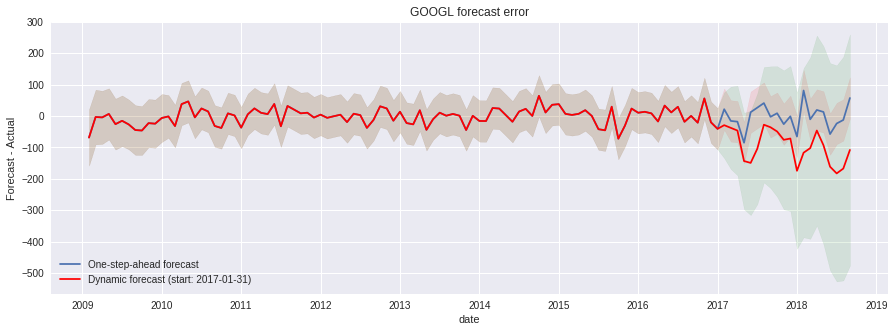

In [229]:
# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(15, 5))
npre = 4
ax.set(title=f'{y.name} forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - y.loc[start_date:]
predict_error.loc[start_date:].iloc[offset_from_diffs:].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc[start_date:].iloc[offset_from_diffs:].copy()
ci.iloc[:,0] -= y.loc[start_date:].iloc[offset_from_diffs:]
ci.iloc[:,1] -= y.loc[start_date:].iloc[offset_from_diffs:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - y.loc[start_date:]
predict_dy_error.loc[start_date:].iloc[offset_from_diffs:].plot(ax=ax, style='r', label=f'Dynamic forecast (start: {dynamic_forecast_start})')
ci = predict_dy_ci.loc[start_date:].iloc[offset_from_diffs:].copy()
ci.iloc[:,0] -= y.loc[start_date:].iloc[offset_from_diffs:]
ci.iloc[:,1] -= y.loc[start_date:].iloc[offset_from_diffs:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower left');
# legend.get_frame().set_facecolor('w')